# Common Test I. Multi-Class Classification

The following notebook is my solution for the Common Test 1. 

In [1]:
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, RocCurveDisplay
from torchvision import transforms

In [3]:
import zipfile
with zipfile.ZipFile("dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("dataset")

# Dataset loading

The following cells load the dataset as files from the storage. I augument the dataset by applying transforms to each image, making a total of 4 transformations for every image in the dataset. 

I then create 2 custom datasets using pytorch Dataset class, and a data module class for using with pytorch lightning

In addition, I found that the usable part of the image lies between 40-120 pixels height and 25-125 pixels width. We crop all images in the custom dataset to this size. The new size is (1,80,100). This reduces the number of parameters in the downstream dense layers. 

In [2]:
train_dir = "dataset/dataset/train/"
val_dir = "dataset/dataset/val/"

In [3]:
# Transforms

transform_to_apply = [
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomRotation([-90, +90]),
]

In [4]:
'''
Loading and augumenting training set. 
Appending path_to_image, label, transform to list. 
'''

train = []
print(os.listdir(train_dir))
for i, label in enumerate(['no', 'sphere', 'vort']):
    if label == ".DS_Store":
        continue
    for f in os.listdir(train_dir + label):
        for transform in transform_to_apply:
            train.append((train_dir + label + "/" + f, i, transform))

['sphere', 'no', '.DS_Store', 'vort']


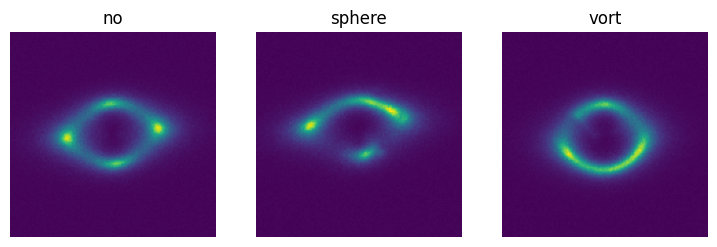

In [5]:
plt.figure(figsize = (9,3))
for i, label in enumerate(['no', 'sphere', 'vort']):
    plt.subplot(1,3,i+1)
    plt.imshow(np.load(train[i*40000][0])[0])
    plt.title(label)
    plt.axis("off")


In [6]:
# Loading and augumenting validation set

val = []
print(os.listdir(val_dir))
for i, label in enumerate(['no', 'sphere', 'vort']):
    if label == ".DS_Store":
        continue
    for f in os.listdir(val_dir + label):
        val.append((val_dir + label + "/" + f, i))

['sphere', 'no', '.DS_Store', 'vort']


In [7]:
len(train)

120000

In [8]:
class LensDataset(Dataset):

    def __init__(self, dataset):
        self.dataset = dataset
        
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        
        data = self.dataset[idx]
        return data[2](torch.Tensor(np.load(data[0])[:,40:120, 25:125])), data[1]

In [9]:
class LensDatasetTest(Dataset):

    def __init__(self, dataset):
        self.dataset = dataset
        
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        
        data = self.dataset[idx]
        return torch.Tensor(np.load(data[0])[:,40:120, 25:125]), data[1]

In [10]:
class LensDataModule(pl.LightningDataModule):
    def __init__(
        self,
        train_data,
        test_data,
        batch_size = 16,
        dataloader_num_workers = 1,
    ) -> None:
        super().__init__()
        self.batch_size = batch_size
        self.dataloader_num_workers = dataloader_num_workers

        self.train_data = train_data
        self.test_data = test_data


    def train_dataloader(self):
        
        return DataLoader(
            LensDataset(self.train_data),
            batch_size=self.batch_size,
            shuffle=True,
            pin_memory=True,
            num_workers=self.dataloader_num_workers
        )
    
    def test_dataloader(self):
        return DataLoader(
            LensDatasetTest(self.test_data),
            batch_size=self.batch_size,
            shuffle=True,
            pin_memory=True,
            num_workers=self.dataloader_num_workers
        )


# Model creation and training

I use the resnet architecture as it is best suited for classification. The following paper tests a variety of architectures - https://ml4physicalsciences.github.io/2019/files/NeurIPS_ML4PS_2019_123.pdf

I use the cross entropy loss for training, train for a total of 20 epochs using a fixed learning rate of 0.0003. 

Pytorch lightning comes to the rescue by automating the training loop and memory management. 

In [11]:
class LensNet(pl.LightningModule):

    def __init__(self):
        super(LensNet, self).__init__()
        self.criterion = nn.CrossEntropyLoss()
        self.model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model.fc = nn.LazyLinear(3)
    
    def forward(self, x):
        return self.model(x)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.0003)
        return [optimizer]
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("accuracy", accuracy_score(y.cpu().numpy(), torch.argmax(y_hat, dim=1).cpu().numpy()),  prog_bar=True)
        return loss
        
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("test_loss", loss)
        
    def predict_step(self, batch, batch_idx):
        x, y = batch
        pred = self(x)
        return pred, y
        

In [12]:
data_module = LensDataModule(train, val)

In [13]:
data_module = LensDataModule(train, val)
model = LensNet()

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.9/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [14]:
trainer = pl.Trainer(max_epochs = 20, accelerator = "gpu", enable_progress_bar = True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [15]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/utilities/model_summary/model_summary.py:411: UserWarning: A layer with UninitializedParameter was found. Thus, the total number of parameters detected may be inaccurate.
  warning_cache.warn(

  | Name      | Type             | Params
-----------------------------------------------
0 | criterion | CrossEntropyLoss | 0     
1 | model     | ResNet           | 11.2 M
-----------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.681    Total estimated model params size (MB)
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improv

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


# Test metrics

We use the classification_report by scikit learn to understand how our model is performing. The AUC and ROC curve is plotted using the ROCCurveDisplay in scikit learn

The classification reports for training and test set show that the model has not overfit on the training set. The AUC and ROC curves show that our model is performing really well, with an AUC of 0.99 for all classes. 

In [16]:
preds_train = trainer.predict(model, data_module.train_dataloader())

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 7500it [00:00, ?it/s]

In [17]:
pred_train = np.zeros((len(preds_train)*16, ))
y_train = np.zeros((len(preds_train)*16, ))

for i, value in enumerate(preds_train):
    try:
        pred_train[i*16:(i+1)*16] = torch.argmax(value[0], dim=1)
        y_train[i*16:(i+1)*16] = value[1]
    except:
        print(i)
        pred_train[i*16:i*16 + value[0].shape[0]] = torch.argmax(value[0], dim=1)
        y_train[i*16:i*16 + value[0].shape[0]] = value[1]

In [18]:
preds = trainer.predict(model, data_module.test_dataloader())

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 7500it [00:00, ?it/s]

In [19]:
pred = np.zeros((len(preds)*16, ))
pred_proba = np.zeros((len(preds)*16, 3))
true = np.zeros((len(preds)*16, ))

for i, value in enumerate(preds):
    try:
        pred[i*16:(i+1)*16] = torch.argmax(value[0], dim=1)
        pred_proba[i*16:(i+1)*16] = F.softmax(value[0], dim=1)
        true[i*16:(i+1)*16] = value[1]
    except:
        print(i)
        pred[i*16:i*16 + value[0].shape[0]] = torch.argmax(value[0], dim=1)
        pred_proba[i*16:i*16 + value[0].shape[0]] = F.softmax(value[0], dim=1)
        true[i*16:i*16 + value[0].shape[0]] = value[1]

468


In [20]:
print(classification_report(y_train, pred_train))

              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96     40000
         1.0       0.99      0.91      0.95     40000
         2.0       0.96      0.98      0.97     40000

    accuracy                           0.96    120000
   macro avg       0.96      0.96      0.96    120000
weighted avg       0.96      0.96      0.96    120000



In [21]:
print(classification_report(true, pred))

              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96      2504
         1.0       0.97      0.89      0.93      2500
         2.0       0.95      0.97      0.96      2500

    accuracy                           0.95      7504
   macro avg       0.95      0.95      0.95      7504
weighted avg       0.95      0.95      0.95      7504



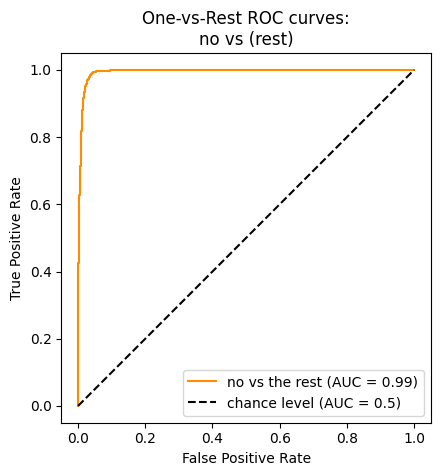

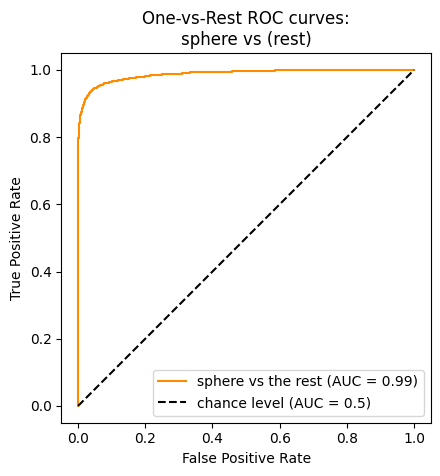

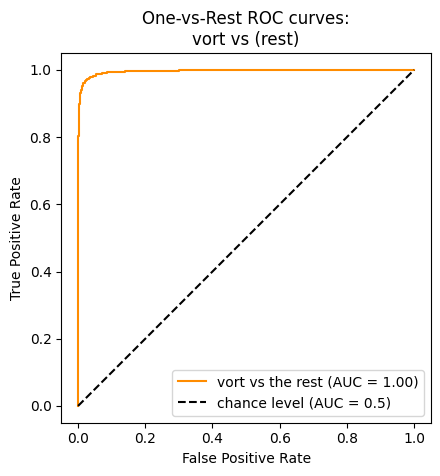

In [24]:
for i, label in enumerate(['no', 'sphere', 'vort']):

    display = RocCurveDisplay.from_predictions(
        (true == i),
        pred_proba[:,i],
        name=f"{label} vs the rest",
        color="darkorange",
    )
    plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"One-vs-Rest ROC curves:\n{label} vs (rest)")
    plt.legend()